## Details

The notebook contains the synthetic data experiment with low noise (sigma^2 = 0.05). Due to the non-convexity of the HNCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
# loading packages and functions
import sys
import itertools

sys.path.append("./src")
from utils import *
import torch
import numpy as np
from matplotlib import pyplot as plt

from multi_ntf import run_single
#
import torch.nn as nn

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

Using numpy backend.


## Generate Data Tensor

In [2]:
## set the network parameters
torch.set_default_tensor_type(torch.DoubleTensor)

X = get_synthetic_tensor(noise=0.4, seed=14)

In [3]:
X_original = get_synthetic_tensor(noise=0)
S_true_7_2, S_true_7_4, S_true_4_2 = get_synthetic_gt_topics()
S_trues = [S_true_7_2, S_true_7_4, S_true_4_2]

### Visualize Original Data Tensor

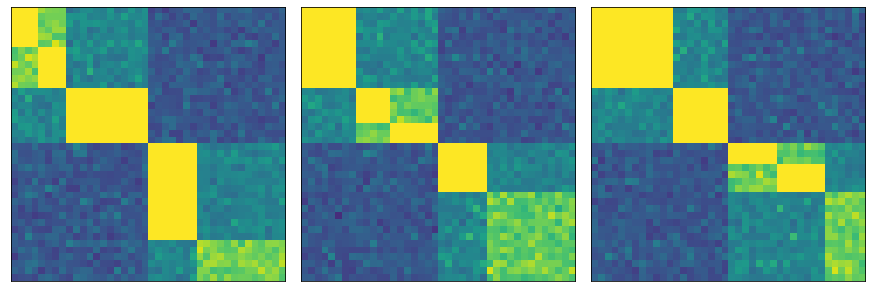

In [4]:
display_tensor(X)

## Run Multi-HNTF

In [5]:
# unsupervised case,one layer
r= [7, 4, 2]
n1,n2,n3 = X.shape

num_trials = 10
N = 800
histories = []
k = 3

for i in range(num_trials):
    
    np.random.seed(i)

    Factors = non_negative_parafac(X, rank=r[0])
        
    W = run_single(X, Factors, r[1], N)
    Factors_2 = [Factors[i] @ W for i in range(k)]
        
    W2 = run_single(X, Factors_2, r[2], N)
    Factors_3 = [Factors_2[i] @ W2 for i in range(k)]
    
    history = {'Factors': Factors, 'Factors_2': Factors_2, 'Factors_3': Factors_3, 'W': W, 'W2': W2}
    histories.append(history)


## Caclulate Loss

In [6]:
recon_losses = [0,0,0]
modeling_losses = [0,0,0]
for history in histories:
    
    Factors = history['Factors']
    Factors_2 = history['Factors_2']
    Factors_3 = history['Factors_3']
    W = history['W']
    W2 = history['W2']
    
    recon_losses[0] += recon_loss(X_original, outer_product_np(Factors))
    recon_losses[1] += recon_loss(X_original, outer_product_np(Factors_2))
    recon_losses[2] += recon_loss(X_original, outer_product_np(Factors_3))
    
    modeling_losses[0] += measure_modeling(W @ W2, S_true_7_2)
    modeling_losses[1] += measure_modeling(W, S_true_7_4)
    modeling_losses[2] += measure_modeling(W2, S_true_4_2)

recon_losses = [loss/len(histories) for loss in recon_losses]
modeling_losses = [loss/len(histories) for loss in modeling_losses]

In [7]:
print(recon_losses)
print(modeling_losses)

[0.4543299379740907, 0.5480417368199686, 0.7212766734112803]
[0.014440187057077059, 0.08505196244207087, 0.13063388084497873]


## Visualization

In [8]:
history = histories[-1]
Factors = history['Factors']
Factors_2 = history['Factors_2']
Factors_3 = history['Factors_3']
W = history['W']
W2 = history['W2']

### All models, Rank 7

Relative reconstruction loss: 0.4543299379741008


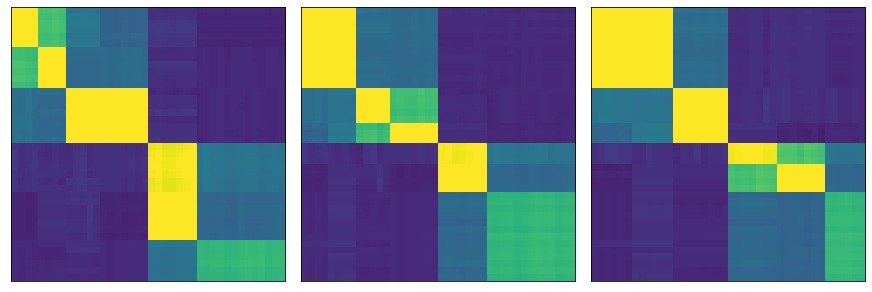

In [9]:
approx = outer_product_np(Factors)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_original-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_original), 2))
display_tensor(approx)

### Multi-HNTF, Rank 4

Relative reconstruction loss: 0.5127640505433915


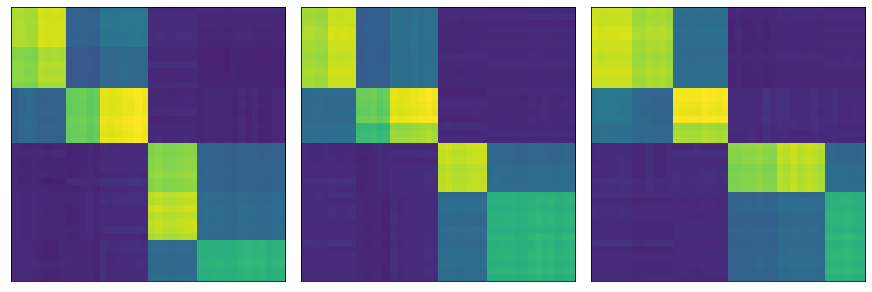

In [10]:
approx = outer_product_np(Factors_2)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_original-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_original), 2))
display_tensor(approx)

### Multi-HNTF, Rank 2

Relative reconstruction loss: 0.7211020803369386


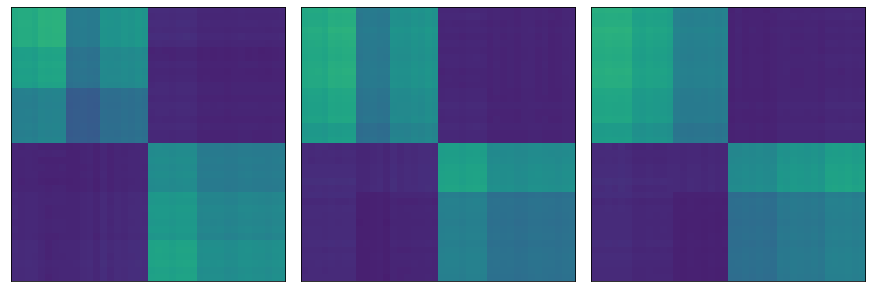

In [11]:
approx = outer_product_np(Factors_3)
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_original-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_original), 2))
display_tensor(approx)

## Extra: Display Topic Modeling (W) Matrices

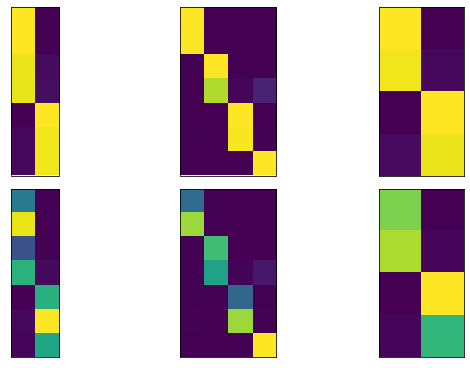

In [12]:
display_topic_matrices([W @ W2, W, W2], S_trues)